# Проект 4. Компьютер говорит «Нет»

## Скоринговая модель предсказания дефолта клиентов банка.

Загрузка и анализданных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from  sklearn.feature_selection import f_classif , mutual_info_classif
from  sklearn.preprocessing import LabelEncoder,  OneHotEncoder , StandardScaler

In [2]:
train = pd.read_csv( 'train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

# Названия признаков и их смысл:
  - client_id - идентификатор клиента
  - education - уровень образования
  - sex - пол заемщика
  - age - возраст заемщика
  - car - флаг наличия автомобиля
  - car_type - флаг автомобиля иномарки
  - decline_app_cnt - количество отказанных прошлых заявок
  - good_work - флаг наличия “хорошей” работы
  - bki_request_cnt - количество запросов в БКИ
  - home_address - категоризатор домашнего адреса
  - work_address - категоризатор рабочего адреса
  - income - доход заемщика
  - foreign_passport - наличие загранпаспорта
  - sna - связь заемщика с клиентами банка
  - first_time - давность наличия информации о заемщике
  - score_bki - скоринговый балл по данным из БКИ
  - region_rating - рейтинг региона
  - app_date - дата подачи заявки
  - default - флаг дефолта по кредиту

In [3]:
# Размеры выборок: Тренировочной, Тестовой и файла Submission
print (train.shape ,test.shape, sample_submission.shape)

(73799, 19) (36349, 18) (36349, 2)


## пропуски

In [4]:
train.isna().sum()

client_id             0
app_date              0
education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
dtype: int64

In [5]:
test.isna().sum()

client_id             0
app_date              0
education           171
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
dtype: int64

<AxesSubplot:>

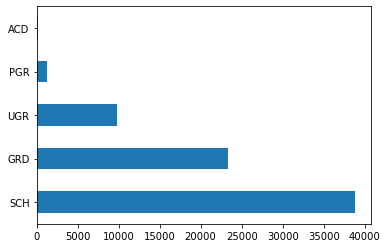

In [6]:
train.education.value_counts().plot.barh()

In [7]:
# заменяем пропуски наиболее часто встречающимся значением
value = train.education.value_counts().index[0]
train['education'] = train['education'].fillna(value)
test['education'] = test['education'].fillna(value)


In [8]:
#бинарные переменные 
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

#категориальные переменные
cat_cols = ['education', 'first_time', 'sna', 'work_address', 'home_address', 'region_rating']

#числовые переменные

num_cols = ['age', 'score_bki', 'decline_app_cnt', 'bki_request_cnt', 'income']



In [9]:
# удаление признаков
train.drop(['client_id','app_date',], axis = 1, inplace=True)
test.drop(['client_id','app_date',], axis = 1, inplace=True)

## числовые переменные

In [10]:
#train, validation = train_test_split(df, test_size=0.33, random_state=42)

In [11]:
train[train['default'] == 1]['age'].mean() > train[train['default'] == 0]['age'].mean()

False

In [12]:
train[train['default'] == 1]['score_bki'].mean() > train[train['default'] == 0]['score_bki'].mean()

True

In [13]:
train[train['default'] == 1]['decline_app_cnt'].mean() > train[train['default'] == 0]['decline_app_cnt'].mean()

True

In [14]:
train[train['default'] == 1]['bki_request_cnt'].mean() > train[train['default'] == 0]['bki_request_cnt'].mean()

True

In [15]:
train[train['default'] == 1]['income'].mean() > train[train['income'] == 0]['income'].mean()

False

/Users/ramanzhuk/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


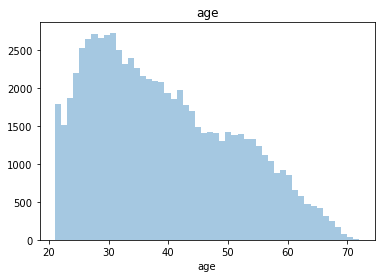

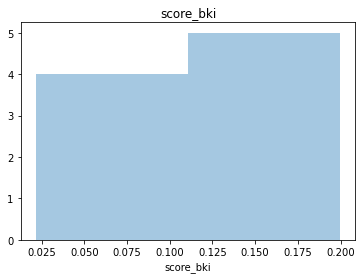

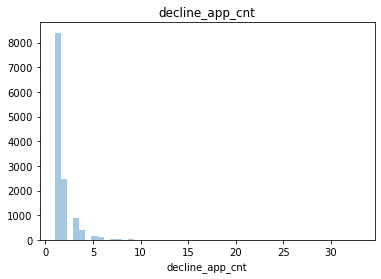

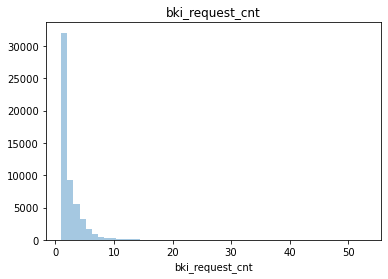

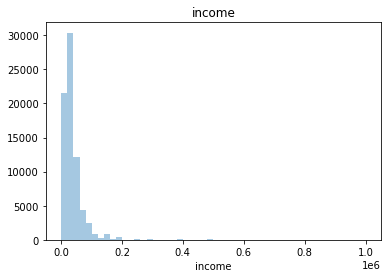

In [16]:
for i in num_cols:
    plt.figure()
    sns.distplot(train[i][train[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

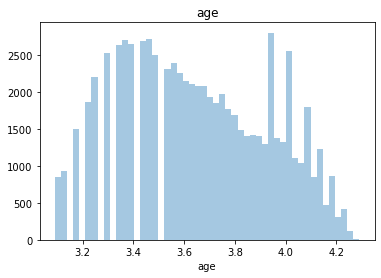

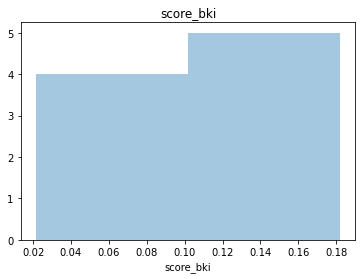

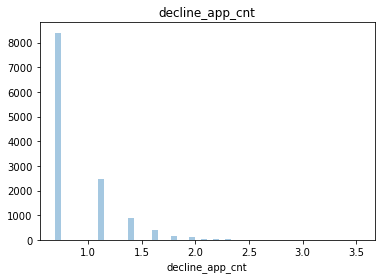

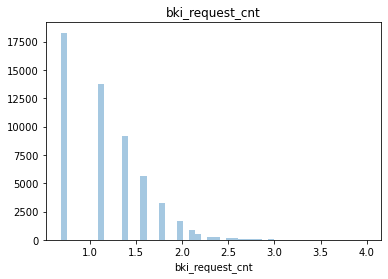

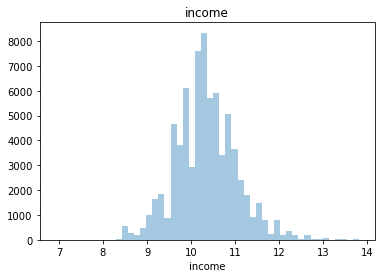

In [17]:
for i in num_cols:
    plt.figure()
    sns.distplot(train[i][train[i] > 0].dropna().apply(lambda w: np.log(w + 1)), kde = False, rug=False)
    plt.title(i)
    plt.show()

In [18]:
# логарифмируем некоторые числовые признаки 
train['age'] = np.log(train['age'] + 1)
test['age'] = np.log(test['age'] + 1)

train['decline_app_cnt'] = np.log(train['decline_app_cnt'] + 1)
test['decline_app_cnt'] = np.log(test['decline_app_cnt'] + 1)

train['income'] = np.log(train['income'] + 1)
test['income'] = np.log(test['income'] + 1)

train['bki_request_cnt'] = np.log(train['bki_request_cnt'] + 1)
test['bki_request_cnt'] = np.log(test['bki_request_cnt'] + 1)

<AxesSubplot:>

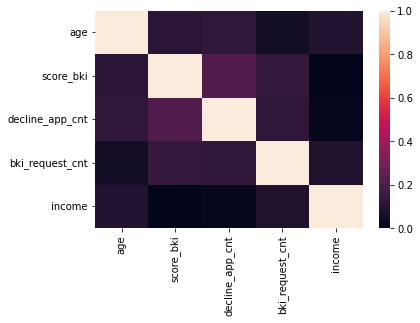

In [19]:
# расчет кореляций между числовыми признакоми
sns.heatmap(train[num_cols].corr().abs(), vmin=0, vmax=1)
# анализ показывает что зависимых признаков нет

<AxesSubplot:>

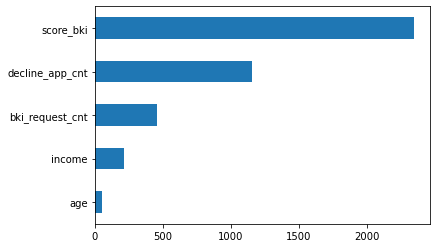

In [20]:
# оценка значимости числовых признаков
imp_num = pd.Series(f_classif(train[num_cols], train['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

## бинарные признаки

In [21]:
# Для бинарных признаков мы будем использовать LabelEncoder

label_encoder = LabelEncoder()

for column in bin_cols:
    train[column] = label_encoder.fit_transform(train[column])
    test[column] = label_encoder.fit_transform(test[column])
    
# убедимся в преобразовании    
train.head()

,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,SCH,1,4.143135,1,1,0.000000,0,-2.008753,0.693147,50,1,2,9.798183,4,1,0,0
1,SCH,0,4.094345,0,0,0.000000,0,-1.532276,1.386294,50,2,3,9.852247,4,1,0,0
2,SCH,1,3.258097,1,0,1.098612,0,-1.408142,0.693147,80,1,2,10.308986,1,4,1,0
3,SCH,0,3.988984,0,0,0.000000,0,-2.057471,1.098612,50,2,3,9.210440,1,3,0,0
4,GRD,1,3.891820,0,0,0.000000,1,-1.244723,0.693147,60,2,3,10.308986,1,4,1,0


## котигориальные признаки

<AxesSubplot:>

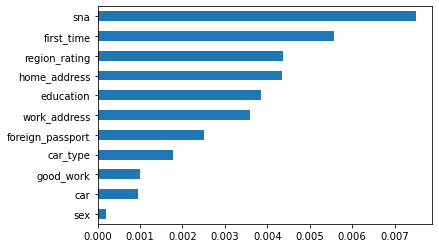

In [22]:
# оценка значимости признаков
train['education'] = label_encoder.fit_transform(train['education'])
test['education'] = label_encoder.fit_transform(test['education'])

imp_cat = pd.Series(mutual_info_classif(train[bin_cols + cat_cols], train['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [23]:
data_train_cat = OneHotEncoder(sparse = False).fit_transform(train[cat_cols].values)
data_test_cat = OneHotEncoder(sparse = False).fit_transform(test[cat_cols].values)

## Подготовка данных и обучение модели

In [24]:
# Стандартизация числовых переменных

data_train_num = StandardScaler().fit_transform(train[num_cols].values)
data_test_num = StandardScaler().fit_transform(test[num_cols].values)

In [25]:
X = np.hstack([data_train_num, train[bin_cols].values, data_train_cat])
X_valid = np.hstack([data_test_num, test[bin_cols].values, data_test_cat])
y = train['default'].values

In [26]:
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
# Импортируем необходимые библиотеки:
from sklearn.linear_model import LogisticRegression # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели
from sklearn.model_selection import GridSearchCV

# запускаем GridSearch 
# чтобы получить оптимальные параметры модели 
model = LogisticRegression()

iter_ = 1000
epsilon_stop = 1e-3

param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]

gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_

##печатаем параметры
best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))

/Users/ramanzhuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ramanzhuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ramanzhuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/ramanzhuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/User

/Users/ramanzhuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ramanzhuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ramanzhuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/ramanzhuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/User

/Users/ramanzhuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ramanzhuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ramanzhuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1358, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/Users/ramanzhuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py", line 939, in _fit_liblinear
    class_weight_ = compute_class_weight(class_weight, classes=classes_,
  File "/Users/ramanzhuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/Users/ramanzhuk/opt

/Users/ramanzhuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan 0.33674694        nan
 0.33676974        nan 0.0514125  0.0514125         nan 0.0514125
 0.0514125  0.0514125  0.0514125         nan 0.0514125  0.0514125
 0.33676724 0.33676746 0.33682319 0.33678963 0.33679051 0.33676724
 0.33676746 0.33682319 0.33688112 0.33681168 0.05140613 0.05140613
 0.05140613 0.05140613 0.05140613 0.05140613 0.05140613 0.05140613
 0.33689059 0.33687929 0.33692555 0.33683453 0.33689059 0.33687929
 0.33691321 0.33684615]
  warnings.warn(


	C: 1.0
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 1000
	multi_class: 'auto'
	n_jobs: None
	penalty: 'none'
	random_state: None
	solver: 'sag'
	tol: 0.001
	verbose: 0
	warm_start: False


In [28]:
# Создадим модель в оптимальными параметрами, найденными с помощью инструмента GridSearchCV

logreg = LogisticRegression(solver='sag', max_iter=1000, class_weight='balanced', penalty='none',  tol=0.001, )
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test) 
Y_pred=logreg.predict(X_train)
y_pred_proba=logreg.predict_proba(X_test)
y_pred_proba=y_pred_proba[:,1]
Y_pred_proba=logreg.predict_proba(X_train)
Y_pred_proba=Y_pred_proba[:,1]

## оценка модели

In [29]:
# Импортируем все необходимые метрики
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, roc_auc_score, roc_curve, recall_score, confusion_matrix

In [30]:
# Функция, отображений  значений всех метрик на тренировочной  и тестовой выборках
def show_metrics(y_pred_train, Y_train, y_pred_test, Y_test, y_pred_proba_train, y_pred_proba_test):
    f1_score_train=f1_score(y_pred_train,Y_train)
    f1_score_test=f1_score(y_pred_test,Y_test)
    print('[train] f1_score {0:.2f}, [test] f1_score {1:.2f}\n'.format(f1_score_train,f1_score_test))
    precision_score_train=precision_score(y_pred_train,Y_train)
    precision_score_test=precision_score(y_pred_test,Y_test)
    print('[train] precision_score {0:.2f}, [test] precision_score {1:.2f}\n'.format(precision_score_train,precision_score_test))
    recall_score_train=recall_score(y_pred_train,Y_train)
    recall_score_test=recall_score(y_pred_test,Y_test)
    print('[train] recall_score {0:.2f}, [test] recall_score {1:.2f}\n'.format(recall_score_train,recall_score_test))
    accuracy_score_train=accuracy_score(y_pred_train,Y_train)
    accuracy_score_test=accuracy_score(y_pred_test,Y_test)
    print('[train] accuracy_score {0:.2f}, [test] accuracy_score {1:.2f}\n'.format(accuracy_score_train,accuracy_score_test))
    roc_auc_score_train=roc_auc_score(Y_train,y_pred_proba_train)
    roc_auc_score_test=roc_auc_score(Y_test,y_pred_proba_test)
    print('[train] roc_auc_score {0:.2f}, [test] roc_auc_score {1:.2f}\n'.format(roc_auc_score_train,roc_auc_score_test))
    confusion_matrix_train=confusion_matrix(y_pred_train,Y_train)
    confusion_matrix_test=confusion_matrix(y_pred_test,Y_test)
    print('[train] confusion_matrix \n {0}, \n[test] confusion_matrix \n {1}\n'.format(confusion_matrix_train,confusion_matrix_test))

In [31]:
# Проверим, нет ли переобучения модели
show_metrics(Y_pred,y_train,y_pred,y_test,Y_pred_proba,y_pred_proba)

[train] f1_score 0.34, [test] f1_score 0.34

[train] precision_score 0.67, [test] precision_score 0.69

[train] recall_score 0.23, [test] recall_score 0.22

[train] accuracy_score 0.67, [test] accuracy_score 0.67

[train] roc_auc_score 0.73, [test] roc_auc_score 0.74

[train] confusion_matrix 
 [[34210  2483]
 [17284  5062]], 
[test] confusion_matrix 
 [[8568  569]
 [4365 1258]]



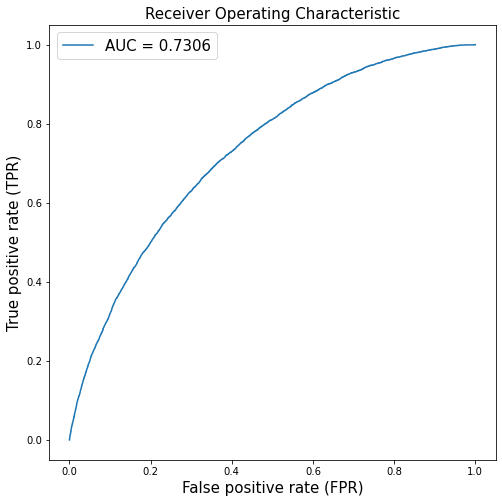

In [32]:
# Посчитать значения ROC кривой и значение площади под кривой AUC
fpr, tpr, thresholds = roc_curve(y_train,Y_pred_proba)
roc_auc = roc_auc_score(y_train,Y_pred_proba)   
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.title('Receiver Operating Characteristic', fontsize=15)
plt.xlabel('False positive rate (FPR)', fontsize=15)
plt.ylabel('True positive rate (TPR)', fontsize=15)
plt.legend(fontsize=15)

In [33]:
# Кажется, переобучения нет. Чтобы проверить это, воспользуемся функцией cross_validate 

from sklearn.model_selection import cross_validate
cv_metrics = cross_validate(logreg, X, y, cv=5, scoring='f1_micro', return_train_score=True)

def plot_cv_metrics(cv_metrics):
    avg_f1_train, std_f1_train = cv_metrics['train_score'].mean(), cv_metrics['train_score'].std()
    avg_f1_valid, std_f1_valid = cv_metrics['test_score'].mean(), cv_metrics['test_score'].std()
    print('[train] F1-score = {:.2f} +/- {:.2f}'.format(avg_f1_train, std_f1_train))
    print('[valid] F1-score = {:.2f} +/- {:.2f}'.format(avg_f1_valid, std_f1_valid))
    
    plt.figure(figsize=(15, 5))

    plt.plot(cv_metrics['train_score'], label='train', marker='.')
    plt.plot(cv_metrics['test_score'], label='valid', marker='.')

    plt.ylim([0., 1.]);
    plt.xlabel('CV iteration', fontsize=15)
    plt.ylabel('F1-score', fontsize=15)
    plt.legend(fontsize=15)

[train] F1-score = 0.67 +/- 0.00
[valid] F1-score = 0.67 +/- 0.00


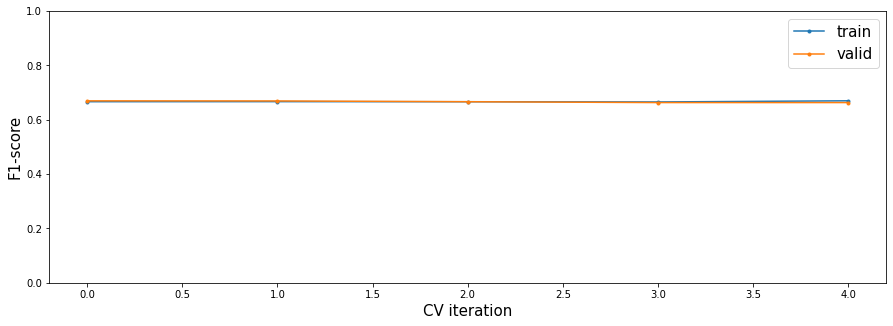

In [34]:
plot_cv_metrics(cv_metrics)
# Переобучения действительно нет

# Получение итогового решения

In [35]:
#  обучаем финальную модель на всех обучающи данных
logreg_final = LogisticRegression(solver='saga', max_iter=1000, class_weight='balanced', penalty='l2',tol=0.001, multi_class='ovr')
logreg_final.fit(X, y)

LogisticRegression(class_weight='balanced', max_iter=1000, multi_class='ovr',
                   solver='saga', tol=0.001)

In [36]:
predict_submission = logreg_final.predict(X_valid)
sample_submission['default'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,client_id,default
0,74835,0
1,17527,1
2,75683,0
3,26883,0
4,28862,0
5,99881,1
6,26630,1
7,79934,0
8,16605,0
9,105449,0
